In [3]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol
from pyccl._core import UnlockInstance

# Ejected Gas & Bound Gas Profiles (separate profiles)

In [6]:
class ejGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the ejected gas density profile
    where: """  # could put in the equations used

    def __init__(self, cosmo, mass_def): 
        super(ejGas_profile, self).__init__(mass_def=mass_def)
        self.cosmo = cosmo

    def _real(self, r, M, delta=200, eta_b = 0.5, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        r_e = 0.375*r_vir*np.sqrt(delta)*eta_b # eta_b = a free parameter

# Returns: float or array_like: halo profile. Shape of output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` and `M` respectively.
        prefix = M_use * (1/(scale_a*np.sqrt(2*np.pi*r_e)))**3
        x = r_use[None, :] / r_e[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _fourier(self, k, M, delta=200, eta_b = 0.5, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        r_e = 0.375*r_vir*np.sqrt(delta)*eta_b # eta_b = a free parameter

        prefix = M_use / scale_a**3
        x = k_use[None, :] * r_e[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)  #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

In [8]:
class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, cosmo, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64): 
        # n_q/Gamma = 2^x
        self.gamma = gamma
        super(boundGas_profile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.cosmo = cosmo

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        self._func_normQ0 = None   # General normalised profile (for q=0, over Gamma)
        self._func_normQany = None

    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): 
        return x**2 * self._shape(x, gam)   

    import scipy.integrate as integrate
    import scipy.interpolate as interpol
    from pyccl._core import UnlockInstance

    def _Vb_prefix(self, r_s=1):
        vB1 = integrate.quad(self._innerInt, 0, np.inf, args = (1/(self.gamma-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(r_s**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 = for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)
        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        func_normQ0 = interpol.interp1d(gamma_list, I0_array) # interp1d(x, y, ...
        return func_normQ0
        
    def _real(self, r, M, call_interp=True, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        
        R_M = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(self.cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if call_interp==False:
            vB_prefix = self._Vb_prefix(r_s)
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = self._norm_interpol1() 
            vB_prefix = 4*np.pi*(r_s**3)*self._func_normQ0(self.gamma)  # self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * (1/scale_a**3) * (1/vB_prefix)
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.

        x = r_use[None, :] / r_s[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(self.gamma-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _norm_interpol2(self):  # interpol1 for q = any
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        q_array = np.geomspace(self.qrange[0], self.qrange[1], self.nq) # q = k*r_s, k will be from geomspace
        I0_array =  np.zeros((self.nGamma, self.nq))

        def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x * self._shape(x, gam) # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]/q
        k=0
        for i in gamma_list: 
            l=0
            for j in q_array: 
                I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                l+=1
            k+=1
            print(f'k = {100*k/self.nGamma:.3g}% through')
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)
        return func_normQany
    
    def _fourier(self, k, M, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        R_M = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if self._func_normQ0 is None: # is instead of == here
            with UnlockInstance(self):
                self._func_normQ0 = self._norm_interpol1() 
        if self._func_normQany is None:
            with UnlockInstance(self):
                self._func_normQany = self._norm_interpol2()

        q_use = k_use[None, :]*r_s[:, None]
        g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0

        prefix = M_use / scale_a**3
        prof = prefix[:, None] * g_k[None,:] 

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

# New Combined Class

Add in equations: $\rho(r)\ = f_b\ \rho_{bound}(r)\ + (1 - f_b)\rho_{ejected}(r)\ $

In [13]:
class combinedGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #boundGas_profile, ejGas_profile): 
    #ccl.halos.profiles.profile_base.HaloProfile): 
    """Text
    """

    def __init__(self, cosmo, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):

        self.gamma = gamma
        super(combinedGas_profile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.boundProfile = boundGas_profile(cosmo=cosmo, mass_def=mass_def, concentration=concentration, gamma=gamma)
        self.ejProfile = ejGas_profile(cosmo=cosmo, mass_def=mass_def)

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

    def _real(self, r, M, f_bd=1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._real(r, M, scale_a) # ejGas_profile._real(self, r, M, scale_a)
        prof_bd = self.boundProfile._real(r, M, call_interp, scale_a) # boundGas_profile._real(self, r, M, call_interp, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd
        return profile

    def _fourier(self, k, M, f_bd = 1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._fourier(k, M, scale_a)
        prof_bd = self.boundProfile._fourier(k, M, scale_a)
        print(np.shape(prof_bd), np.shape(prof_ej))
        profile = f_ej*prof_ej + f_bd*prof_bd[0]
        print(np.shape(profile))
        return profile

# Trial

In [142]:
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
# change h=0.07 to h=0.7

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1  # working with z = 0 (today) ; therefore a = 1 [default]
#trial_rEj = 100
#trial_rS = 1       

In [144]:
trial_profile = combinedGas_profile(cosmo, hmd_200c, cM, trial_gamma) #, trial_rEj)

## Real

In [147]:
trial_f_bd = 0.2
profTrial_real = trial_profile._real(trial_r, trial_M, #trial_rEj, 
                                     trial_f_bd) 
# _real(self, r, M, r_ej, f_bd=1, call_interp=True, scale_a=1)
profTrial_real

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20324/1177319704.py:41: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20324/1177319704.py:41: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))


array([[5.26476860e+14, 5.26396078e+14, 5.26315291e+14, ...,
        2.47461204e-64, 2.46918924e-64, 2.46377832e-64],
       [5.20989852e+14, 5.20944087e+14, 5.20898316e+14, ...,
        4.30501031e-62, 4.29558957e-62, 4.28618945e-62],
       [4.67013424e+14, 4.66993707e+14, 4.66973987e+14, ...,
        1.70119897e-59, 1.69748262e-59, 1.69377437e-59]])

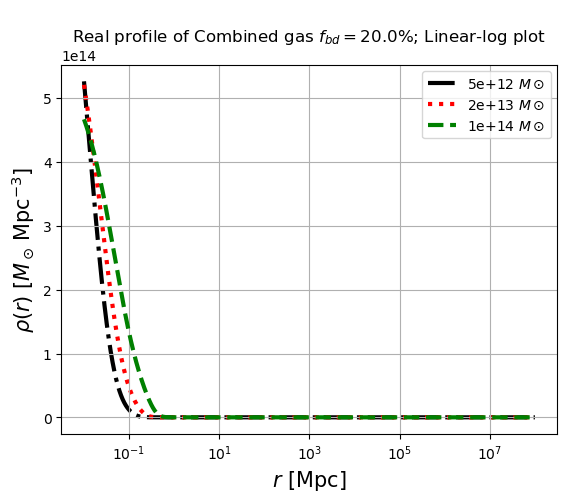

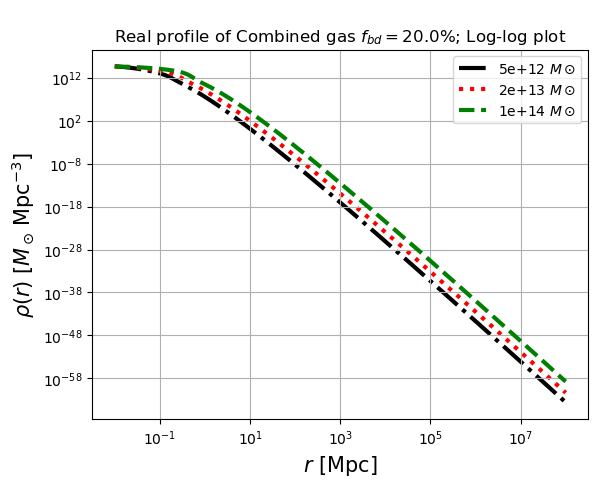

In [148]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_real = '\nReal profile of Combined gas $f_{bd}=$'+f'{trial_f_bd*100}%;' 
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');  

## Fourier

In [156]:
trial_k = np.geomspace(5E-3,1E2,100_000) # np.geomspace(1E-3,1E2,100000)
profTrial_fourier = trial_profile._fourier(trial_k, trial_M, #trial_rEj, 
                                           trial_f_bd)
profTrial_fourier  #_fourier(self, k, M, r_ej, f_bd = 1, call_interp=True, scale_a=1)

(1, 3, 100000) (3, 100000)
(3, 100000)


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20324/1177319704.py:109: RuntimeWarning: overflow encountered in divide
  g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20324/1177319704.py:112: RuntimeWarning: overflow encountered in multiply
  prof = prefix[:, None] * g_k[None,:]


array([[4.99997294e+12, 4.99997294e+12, 4.99997294e+12, ...,
                   inf,            inf,            inf],
       [1.99998637e+13, 1.99998637e+13, 1.99998637e+13, ...,
                   inf,            inf,            inf],
       [9.99987509e+13, 9.99987507e+13, 9.99987505e+13, ...,
                   inf,            inf,            inf]])

#### Normalisation of profiles means that:   
$\rho(k \to 0)\ _x = \frac{M_x}{a^3} [f_x]$   
For the combined gas profile, $\rho(r)\_{cbd} = \rho(r)\_{ej} + \rho(r)\_{bd}$    
And: $\rho(k)\_{cbd} = \rho(k)\_{ej} + \rho(k)\_{bd}$   
So: $\rho(k \to 0)\_{cbd} = f_{ej}\ \frac{M_{ej}}{a^3} + f_{bd}\ \frac{M_{bd}}{a^3} = \ $ (as $f_{ej} + f_{bd} \equiv 1 here$) $ = \frac{M_{cbd}}{a^3}$
#### So plotting $y = x + \frac{M_x}{a^3} [f_x]$ should give an overlap with the [normalised] Fourier density profile's plateau

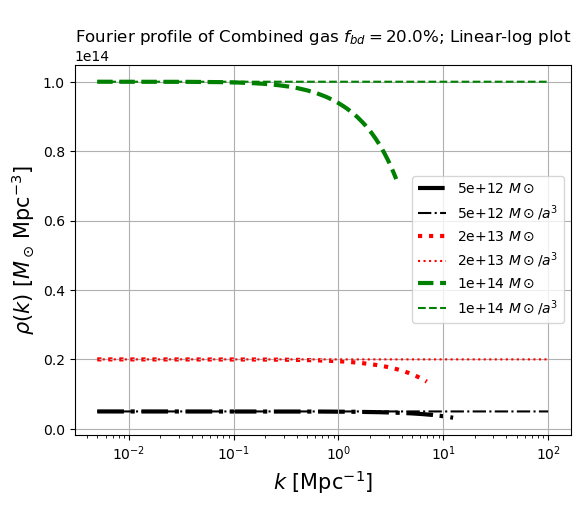

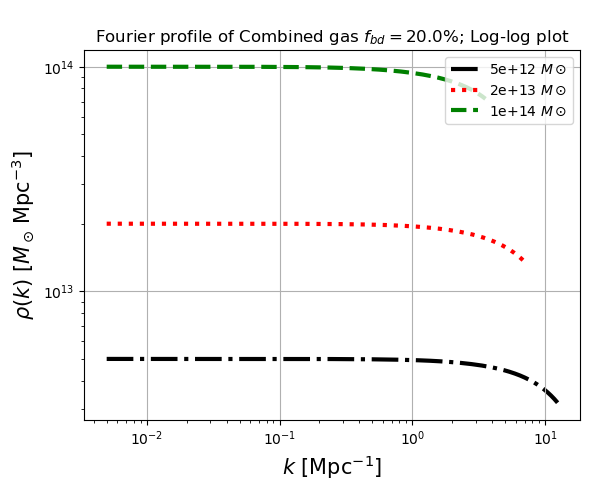

In [159]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_fourier = '\nFourier profile of Combined gas $f_{bd}=$'+f'{trial_f_bd*100}%;' 
for mass, col, fourier in zip(trial_M, colours, profTrial_fourier):
    plt.plot(trial_k, fourier, col, lw=3, zorder = i, label=f'{mass:.1g} $M \\odot $')
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(10-i), label=f'{mass:.1g} $M \\odot /a^3$')  # here, a=1
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_k, profTrial_fourier[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

## Should get: $4 \pi \int^{\infty}_0 r^2 g(r) dr = 1 $, when normalised by mass

In [32]:
#print('ejected: ', integrate.simpson(4*np.pi*(trial_r**2)*ej_real, x = trial_r)/trial_M)
#print('bound: ', integrate.simpson(4*np.pi*(trial_r**2)*bd_real_noInterp, x = trial_r)/trial_M)

integrate.simpson(4*np.pi*(trial_r**2)*profTrial_real, x = trial_r)/trial_M

array([0.17398164, 0.31006242, 0.6464462 ])

In [34]:
import BCMprofiles_Copy2 as BCMprofiles
import scipy.integrate as integrate
BCMprofiles.__all__

/Users/lambe/Documents/GitHub/Oxford-Intern-2024/Oxford-Internship-Practices/BCMprofiles_Copy2.py:12: SyntaxWarning: invalid escape sequence '\ '
  """Creating a class for the stellar density profile
/Users/lambe/Documents/GitHub/Oxford-Intern-2024/Oxford-Internship-Practices/BCMprofiles_Copy2.py:101: SyntaxWarning: invalid escape sequence '\ '
  """Creating a class for the bound gas density profile where:
/Users/lambe/Documents/GitHub/Oxford-Intern-2024/Oxford-Internship-Practices/BCMprofiles_Copy2.py:355: SyntaxWarning: invalid escape sequence '\e'
  """Combined profile for the stellar & ejected & bound gas & cdm components (ie- The BCM Model), with the truncated Navarro-Frenk-White (NFW) profile used to calculate the density profiles of the cold dark matter (cdm) component.


('StellarProfile',
 'EjectedGasProfile',
 'BoundGasProfile',
 'CombinedGasProfile',
 'CombinedStellarGasProfile',
 'CombinedAllBCMProfile')

In [132]:
class CombinedGasProfile(ccl.halos.profiles.profile_base.HaloProfile): 
    def __init__(self, cosmo, mass_def, concentration, gamma, fourier_analytic = True, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):
        self.gamma = gamma
        super(CombinedGasProfile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.boundProfile = BCMprofiles.BoundGasProfile(cosmo=cosmo, mass_def=mass_def, concentration=concentration, gamma=gamma)
        self.ejProfile = BCMprofiles.EjectedGasProfile(cosmo=cosmo, mass_def=mass_def)
        self.fourier_analytic = fourier_analytic
        if fourier_analytic is True:
            self._fourier = self._fourier_analytic

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

    def _real(self, cosmo, r, M, scale_a=1, f_bd=1, call_interp=True):
        print(scale_a, f_bd, call_interp)
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._real(cosmo, r, M, scale_a) 
        print(integrate.simpson(4*np.pi*(r**2)*prof_ej, x = r)/M)
        prof_bd = self.boundProfile._real(cosmo, r, M, scale_a, call_interp) 
        print(integrate.simpson(4*np.pi*(r**2)*prof_bd, x = r)/M)
        profile = f_ej*prof_ej + f_bd*prof_bd
        print(integrate.simpson(4*np.pi*(r**2)*profile, x = r)/M)
        return profile

    def _fourier_analytic(self, k, M, f_bd = 1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._fourier(k, M, scale_a)
        prof_bd = self.boundProfile._fourier(k, M, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd[0]
        return profile


In [98]:
ej_profile = BCMprofiles.EjectedGasProfile(cosmo, hmd_200c)
bd_profile = BCMprofiles.BoundGasProfile(cosmo, hmd_200c, cM, trial_gamma)

In [100]:
ej_real = ej_profile._real(cosmo, trial_r, trial_M)
bd_real = bd_profile._real(cosmo, trial_r, trial_M)
bd_real_noInterp = bd_profile._real(cosmo, trial_r, trial_M, call_interp=False)

False


In [102]:
print('ejected: ', integrate.simpson(4*np.pi*(trial_r**2)*ej_real, x = trial_r)/trial_M)
print('bound: ', integrate.simpson(4*np.pi*(trial_r**2)*bd_real, x = trial_r)/trial_M)
print('bound, no interp: ', integrate.simpson(4*np.pi*(trial_r**2)*bd_real_noInterp, x = trial_r)/trial_M)

ejected:  [1. 1. 1.]
bound:  [0.18956914 0.18962456 0.18963561]
bound, no interp:  [0.99964006 0.99993231 0.9999906 ]


In [134]:
gas_profile = CombinedGasProfile(cosmo, hmd_200c, cM, trial_gamma)

In [140]:
gas_real = gas_profile._real(cosmo, trial_r, trial_M, 1, trial_f_bd, call_interp=False)

1 0.2 False
[1. 1. 1.]
False
[0.99964006 0.99993231 0.9999906 ]
[0.99992801 0.99998646 0.99999812]


In [128]:
integrate.simpson(4*np.pi*(trial_r**2)*gas_real, x = trial_r)/trial_M

array([0.18956914, 0.18962456, 0.18963561])